In [1]:
import os

download_name = "imdb.zip"
if not os.path.exists("imdb.zip"):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a01/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()

name = "imdb"
if not os.path.exists(name):
    from zipfile import ZipFile
    with ZipFile(download_name) as zf:
        zf.extractall(path=name)
    
name = "stopwords.txt"
if not os.path.exists(name):
    name = "stopwords.txt"
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a01/{name}")
    with open(name, "wb") as fp:
        fp.write(response.content)

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
from itertools import chain

# 1. Read data

Path "data/imdb/pos" has 1000 txt files with positive movie reviews.  
Path "data/imdb/neg" has 1000 txt files with negative movie reviews.  
Each text filename incorporates counter. For example, "data/imdb/pos/pos009_29592.txt".  
Return dictionary with keys "pos" and "neg" where value of "pos" is a list of text filename content sorted by filename.

In [3]:
data = {}
folder = "imdb"
for cat in os.listdir(folder):
    path = os.path.join(folder, cat)
    if not os.path.isdir(path):
        continue
    data[cat] = []
    
    for fname in sorted(os.listdir(path)):
        if not fname.endswith(".txt"):
            continue
        fname = os.path.join(path, fname)
        data[cat].append(open(fname).read())

data["pos"][:2]

['films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before . \nfor starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen . \nto say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . \nthe book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . \nin other words , don\'t dismiss this film because of its source . \nif you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes . \ngetting the hughes brothers to direct this see

# 1.  Read stop words

Path "data/stopwords.txt" contains english stop words.  
Read stopwords from file and store them in a set.

In [4]:
stopwords = set()
with open("stopwords.txt") as fp:
    for w in fp:
        stopwords.add(w.rstrip())
        
stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'fill',
 'find',
 'fire',
 'first',
 'five',
 'for'

# 2. Tokenization

Create function *tokenize* which: 
* for a given text 
* returns list of tokens in lower cases (token can contain only letters)

In [5]:
def tokenize(text):
    for tok in text.split():
        if tok.isalpha():
            yield tok.lower()

list(tokenize(data["neg"][0]))

['plot',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 'drink',
 'and',
 'then',
 'drive',
 'they',
 'get',
 'into',
 'an',
 'accident',
 'one',
 'of',
 'the',
 'guys',
 'dies',
 'but',
 'his',
 'girlfriend',
 'continues',
 'to',
 'see',
 'him',
 'in',
 'her',
 'life',
 'and',
 'has',
 'nightmares',
 'the',
 'deal',
 'watch',
 'the',
 'movie',
 'and',
 'sorta',
 'find',
 'out',
 'critique',
 'a',
 'movie',
 'for',
 'the',
 'teen',
 'generation',
 'that',
 'touches',
 'on',
 'a',
 'very',
 'cool',
 'idea',
 'but',
 'presents',
 'it',
 'in',
 'a',
 'very',
 'bad',
 'package',
 'which',
 'is',
 'what',
 'makes',
 'this',
 'review',
 'an',
 'even',
 'harder',
 'one',
 'to',
 'write',
 'since',
 'i',
 'generally',
 'applaud',
 'films',
 'which',
 'attempt',
 'to',
 'break',
 'the',
 'mold',
 'mess',
 'with',
 'your',
 'head',
 'and',
 'such',
 'lost',
 'highway',
 'memento',
 'but',
 'there',
 'are',
 'good',
 'and',
 'bad',
 'ways',
 'of',
 'making',
 'all',
 'type

# 3. Word counter

Create function *make_counter* which: 
* receives corpus (a list of strings) and set of stopwords,
* tokenize each string, 
* remove stop words and 
* returns dictionary whose keys are tokens and values frequencies.

Note: `Counter` class from `collections` module can be used  
`from collections import Counter`

In [6]:
def make_counter(corpus, stopwords):
    count_vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=tokenize)
    count = count_vectorizer.fit_transform(corpus).toarray()
    vocab = count_vectorizer.get_feature_names_out()
    return Counter(dict(zip(vocab, count.sum(axis=0))))

make_counter(data["neg"][:2], stopwords)

Counter({'accident': 1,
         'acting': 2,
         'action': 1,
         'actors': 1,
         'actually': 2,
         'ago': 1,
         'american': 1,
         'apparently': 2,
         'apparitions': 1,
         'applaud': 1,
         'arrow': 1,
         'assuming': 1,
         'attempt': 1,
         'audience': 2,
         'average': 1,
         'away': 2,
         'bad': 2,
         'baldwin': 3,
         'beauty': 1,
         'bentley': 1,
         'big': 2,
         'biggest': 2,
         'bit': 1,
         'blair': 1,
         'body': 1,
         'brain': 1,
         'break': 1,
         'bringing': 1,
         'brother': 1,
         'bug': 1,
         'came': 1,
         'cgi': 1,
         'character': 1,
         'characters': 1,
         'chase': 2,
         'chasing': 1,
         'chopped': 1,
         'church': 1,
         'clue': 1,
         'comes': 1,
         'coming': 2,
         'completely': 1,
         'concept': 1,
         'confusing': 1,
         'continues

# 4. Term frequency - inverse term frequency

Create function *make_tfidf* which: 
* receives corpus and stopwords, and
* returns tensor whose size is #doc x #words

Note: Use `TfidfVectorizer` from `sklearn.feature_extraction.text`.  
Instantiate `TfidfVectorizer` by setting `stop_words` and `tokenizer` arguments.


In [7]:
def make_tfidf(corpus, stopwords):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)
    tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()
    # vocab = tfidf_vectorizer.get_feature_names_out()
    return torch.tensor(tfidf)

make_tfidf(data["neg"][:2], stopwords)


tensor([[0.0493, 0.0000, 0.0000, 0.0493, 0.0987, 0.0493, 0.0493, 0.0987, 0.0493,
         0.0493, 0.0493, 0.0493, 0.0493, 0.0987, 0.0000, 0.0987, 0.0987, 0.0000,
         0.0493, 0.0493, 0.0351, 0.0987, 0.0493, 0.0493, 0.0000, 0.0000, 0.0493,
         0.0000, 0.0000, 0.0000, 0.0493, 0.0000, 0.0493, 0.0493, 0.0351, 0.0493,
         0.0493, 0.0493, 0.0493, 0.0000, 0.0987, 0.0493, 0.0493, 0.0493, 0.0493,
         0.0987, 0.0493, 0.0493, 0.0000, 0.0493, 0.0000, 0.0493, 0.0987, 0.0000,
         0.0000, 0.0987, 0.0493, 0.0493, 0.0493, 0.0000, 0.0000, 0.0493, 0.0987,
         0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0000, 0.0493, 0.0493,
         0.0493, 0.0493, 0.0000, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493,
         0.0493, 0.0987, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493,
         0.0493, 0.0493, 0.0351, 0.0493, 0.2467, 0.0987, 0.0493, 0.0000, 0.0000,
         0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493,
         0.0702, 0.0702, 0.0

## 5.1. Most common words

Count words from positive and negative reviews by using `make_counter`.  
List top ten most common words.

In [8]:
counter = make_counter(data["pos"] + data["neg"], stopwords)
pd.DataFrame(counter.most_common(10), columns=["word", "freq"])


,word,freq
0,film,8849
1,movie,5429
2,like,3543
3,just,2900
4,good,2313
5,time,2280
6,story,2110
7,character,1902
8,characters,1813
9,way,1668


## 5.2. Plot word frequencies

Make scatter plot where:
* x axis represents words sorted by frequencies and
* y axis are frequencies (use log scale for this axis)

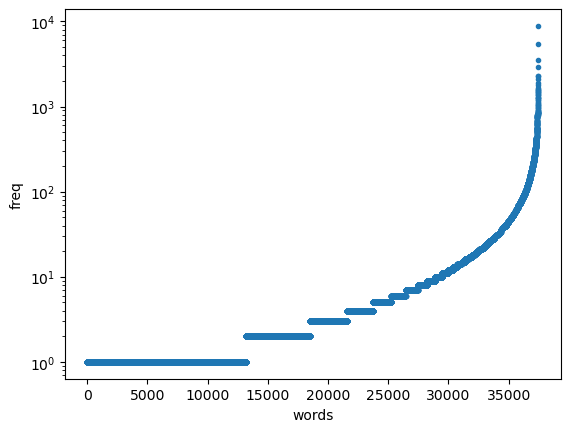

In [9]:
freqs = sorted(counter.values())

plt.scatter(range(len(freqs)), freqs, marker=".")
plt.ylabel("freq")
plt.xlabel("words")
plt.yscale("log")

plt.show()

## 6.1. TF-IDF tensor

Make TF-IDF tensor for positive and negative reviews. Tensor must have 2000 rows (1000 positive and 1000 negative reviews).  
Calculate ratio of non-zero values in the TF-IDF tensor.

In [10]:
tfidf = make_tfidf(data["pos"] + data["neg"], stopwords)
tfidf

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [11]:
tfidf.count_nonzero() / torch.prod(torch.tensor(tfidf.shape))

tensor(0.0062)

## 6.2. TF-IDF tensor slicing

Create two tensors, one for positive and one for negative reviews by slicing previously made TF-IDF tensor of both reviews.

In [12]:
n_pos = len(data["pos"])

tfidf_pos = tfidf[:n_pos,:]
tfidf_neg = tfidf[n_pos:,:]

## 6.3. Similarity

Create similarity tensor whose (i, j) value is cosine similarity of i-th positive review and j-th negative review.  
Cosine similarity between two vectors $u$ and $v$ is 
$$cos(u, v) = \frac{uv}{\lVert u \rVert \lVert v \rVert} = \frac{\sum_{i=1}^{n} u_i v_i}{\sqrt{\sum_{i=1}^{n} u_i^2} \sqrt{\sum_{i=1}^{n} v_i^2}}$$

In [13]:
norm_pos = torch.sum(tfidf_pos, axis=1) ** 0.5
norm_neg = torch.sum(tfidf_neg, axis=1) ** 0.5

sim = torch.mm(tfidf_pos, tfidf_neg.T)
sim = sim / (norm_pos * norm_neg.unsqueeze(0))

sim

tensor([[0.0034, 0.0033, 0.0042,  ..., 0.0026, 0.0031, 0.0036],
        [0.0032, 0.0024, 0.0047,  ..., 0.0020, 0.0035, 0.0023],
        [0.0032, 0.0041, 0.0039,  ..., 0.0022, 0.0029, 0.0025],
        ...,
        [0.0015, 0.0025, 0.0022,  ..., 0.0013, 0.0028, 0.0014],
        [0.0036, 0.0040, 0.0058,  ..., 0.0028, 0.0044, 0.0021],
        [0.0053, 0.0042, 0.0057,  ..., 0.0028, 0.0031, 0.0027]],
       dtype=torch.float64)

## 6.4. Most similar positive and negative review

Find most similar positive and negative review. 
Print their sorted tokenized text without stopwords.

In [14]:
max_sim_indices = (sim == torch.max(sim)).nonzero()

pos_i, neg_i = max_sim_indices[0]
max_sim_indices, torch.max(sim)

(tensor([[789, 697]]), tensor(0.0725, dtype=torch.float64))

In [15]:
pos_tokens = sorted(tok for tok in tokenize(data["pos"][pos_i]) if tok not in stopwords)

print(" ".join(pos_tokens))

accident actually alvarado angeles animals animatronic appreciate apprehended attending attention audience babe bad bad bambi basement basement beings best biggest billing bird bird bird bird bird bird bird bird bird birthday birthday bites blamed boyfriend break buddy buy buying calls cameos cartoons cat cat cat cat characterization characters characters cheech christmas come creature crowd cruel currently customer cute cute dads dalmatian day day dies discovers disney doing doubles dressed eccentric eccentric eisenberg elderly elderly elderly end ends example exclaim experiencing explaining explains facility facility falls finally forth friend friend friend friend friends friends friends furball gena gena gets girl good good goodbye got got hackett hackett hallie heads hear hear help home home home home human human human human hysterically idea imagine impediment impression imprisoned infant influence ingredients interesting ivy ivy janitor jay jay jay jennifer jewelry kate kid kids 

In [16]:
neg_tokens = sorted(tok for tok in tokenize(data["neg"][neg_i]) if tok not in stopwords)

print(" ".join(neg_tokens))

acted action actress add age ages allows animal animals antics atms audience autobiography awesome bad beauty begins believe benny benny best best big biggest bird bird bird bird bird body brain brings calls cat cat character character character charm cheech chef cinematic clashing comedic comedy comes complaint composed confined contains cope creates cringes crisp crook cut cute cymbals dad dancing daughter dead definite deliberately delightful designed director dissolve doses dreamy eisenberg elicit enchanting ensues enthralling example excellent explains explode family family feels finally fine flight fly frequently friend funny gave gave genuine gets gets gina gives good good good got hairball half hallie hand heart heavy home humans humor humor humor hums immigrant impediment instant insulting janitor jay jeffrey john john kate keeps kind knows lab laurie lead learn lends length let like like lines listen literature lives living long long long loud makes manages marie marie marie 